<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# This loads some custom styles for matplotlib
import json, matplotlib

with open("../_static/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

np.random.seed(
    42
)  # This makes our random numbers reproducible when the notebook is rerun in order

# Writing a Markov Chain Monte Carlo Routine

Right now we have:
1. A function to evaluate the energy of a state
1. That code now lives in a python module called MCFF that we can import
1. We've also got some nice tests running that give us some confidence the code is right.


There isn't that much more work to do Markov Chain Monte Carlo. I won't go into the details of how MCMC works but put very simply MCMC lets us calculate thermal averages of a physical system at some temperature. For example, the physical system might be "[$10^{23}$][wa] H20 molecules in a box" and the thermal average we want is "Are they organised like a solid or a liquid?". We can ask that question at different temperatures, and we will get different answers.


For our Ising model the equivalent question would be what's the average color of this system? At high temperatures we expect the pixels to be random and average out grey, while at low temperatures they will all be either black or white.

What happens in between? This question is pretty hard to answer using maths, it can be done for the 2D Ising model but for anything more complicated it's pretty much impossible. This is where MCMC comes in.

MCMC is a numerical method that lets us calculate these thermal averages. MCMC is essentially a description of how to probabilistically step from one state of the system to another. 

If we perform these steps many times we get a (Markov) chain of states. The great thing about this chain is that if we average a measurement over it, such as looking at the average proportion of white pixels, the answer we get will be close to the real answer for this system and will converge closer and closer to the true answer as we extend the chain. 

I've written a very basic MCMC sampler for the 2D Ising model below. It needs:
- an initial place to start the chain from
- how many steps to take
- the temperature we want to simulate at
- a way to measure the energy of a state, which we wrote in a previous chapter

It then loops over:
- modify the state a little, here we just flip one bond
- accepting $p = \exp(-\Delta_E / T)$ based on how the energy changed
- if we rejected, change the state back to how it was

[wa]: https://www.wolframalpha.com/input?i=%28mass+of+1+litre+of+water+%29%2F%28molecular+weight+of+H2O+*+atomic+mass%29

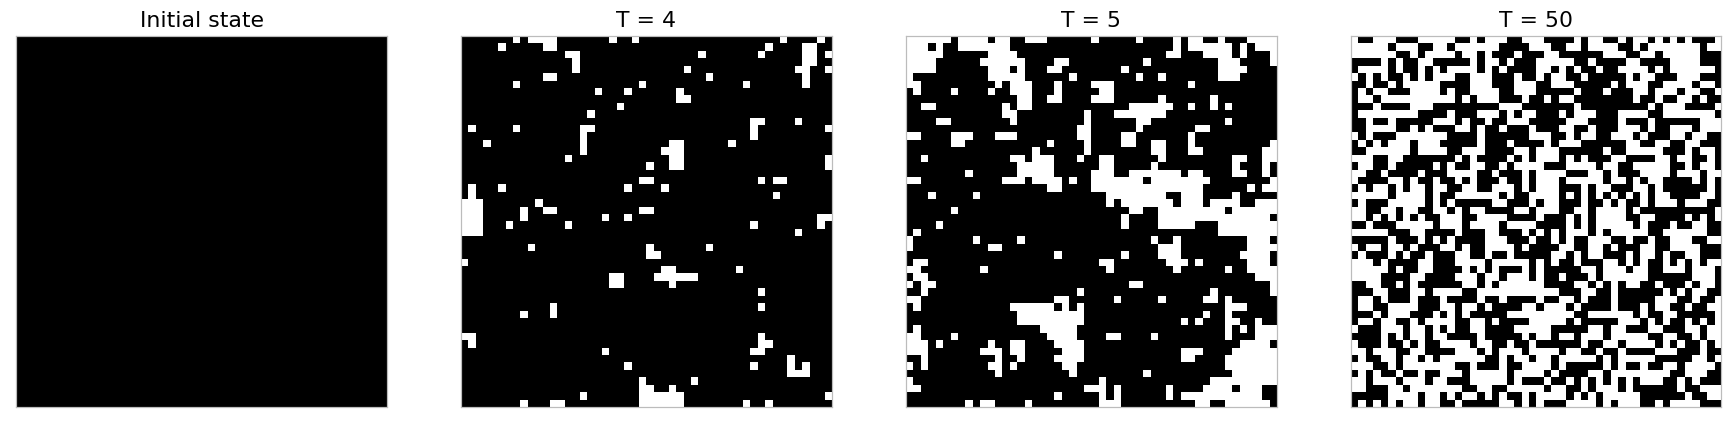

In [2]:
from MCFF.ising_model import energy, show_state

# While writing numba it's useful to keep the list of supported numpy functions open:
# https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html
@jit(nopython=True, nogil=True)
def mcmc(initial_state, steps, T, energy=energy):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    E = energy(current_state)
    for i in range(steps):
        i, j = np.random.randint(N), np.random.randint(N)

        # modify the state a little, here we just flip a random pixel
        current_state[i, j] *= -1
        new_E = energy(current_state)

        if (new_E < E) or np.exp(-(new_E - E) / T) > np.random.random():
            E = new_E
        else:
            current_state[i, j] *= -1  # reject the change we made

    return current_state


Ts = [4, 5, 50]

ncols = 1 + len(Ts)
f, axes = plt.subplots(ncols=ncols, figsize=(5 * ncols, 5))

initial_state = np.ones(shape=(50, 50))
axes[0].set(title="Initial state")
show_state(initial_state, ax=axes[0])

for T, ax in zip(Ts, axes[1:]):
    # initial_state = rng.choice([1,-1], size = (50,50))

    final_state = mcmc(initial_state, steps=100_000, T=T)
    show_state(final_state, ax=ax)
    ax.set(title=f"T = {T}")

These images give a flavour of why physicists find this model useful, it gives a window into how thermal noise and spontaneous order interact. At low temperatures the energy cost of being different from your neighbours is the most important thing, while at high temperatures, it doesn't matter, and you really just do your own thing.

There's a special point somewhere in the middle called the critical point $T_c$ where all sorts of cool things happen, but my favourite is that for large system sizes you get a kind of fractal behaviour which I will demonstrate more once we've sped this code up and can simulate larger systems in a reasonable time. You can kinda see it for a 50x50 system at T = 5 but not really clearly.

## Where do we go from here?

The code we have so far is really just a sketch of a solution. So this is a good time to step back and think about what are aims are and how this software will fulfil them. I see three broad areas on which it needs improvement:

**Functionality**
Right now we can't really do much except print nice pictures of states, but (within the fiction of this project) we really want to be able to do science! So we need to think about what measurements and observations we might want to make and how that might affect the structure of our code.

**Testing**
I've already missed at least one devastating bug in this code, and there are almost certainly more! Before we start adding too much new code we should think about how to increase our confidence that the individual components are working correctly. It's very easy to build a huge project out of hundreds of functions, realise there's a bug and then struggle to find the source of that bug. If we test our components individually and thoroughly, we can avoid some of that pain.

**Performance**
Performance only matters in so far as it limits what we can do. And there is a real danger that trying to optimise for performance too early or in the wrong places will just lead to complexity that makes the code harder to read, harder to write and more likely to contain bugs. However, I do want to show you the fractal states at the critical point, and I can't currently generate those images in a reasonable time, so some optimisation will happen!

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -g -r -b -a "Thomas Hodson" -gu "T_Hodson"

Author: Thomas Hodson

Github username: T_Hodson

Last updated: Mon Jul 18 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Git hash: 03657e08835fdf23a808f59baa6c6a9ad684ee55

Git repo: https://github.com/ImperialCollegeLondon/ReCoDE_MCMCFF.git

Git branch: main

numpy     : 1.21.5
json      : 2.0.9
matplotlib: 3.5.1

Watermark: 2.3.1

